In [107]:
% matplotlib inline

In [108]:
import tensorflow as tf
import pickle
import pandas as pd
import sys
from matplotlib import pyplot as plt
import numpy as np

In [109]:
class TF_Agent():
    
    def __init__(self, keys):
        self._initialize(keys)
        
    def _initialize(self, keys):
        np.random.seed(0)
        self.log_df = pd.DataFrame({key: [] for key in keys})
        self.keys = self.log_df.columns
        self.interesting = ",".join(self.log_df.columns)
        self.iter_count = 0     

    def set_batch(self, n, feed_dict):
        
        keys = list(feed_dict.keys())
        
        data_n = len(feed_dict[keys[0]])
        indices = np.random.choice(range(data_n), n, replace=False)
        
        feed_dict = {key: feed_dict[key][indices] for key in keys}
        self.feed_dict = feed_dict
    
    def run_session(self, sess):
        
        values = sess.run(eval(self.interesting),
                          feed_dict=self.feed_dict)
        
        self.recent_log = pd.Series(values, index=self.keys)
        self.log_df = self.log_df.append([self.recent_log])
        
        self.iter_count += 1
        
    def trace(self, *args, one_line_text=""):
        
        iter_count = self.iter_count
        deco = ["-", "\\", "|", "/"][iter_count%4]
        
        one_line_text = "Iter: % 6d"%iter_count
        for arg in args:
            one_line_text += " %s %s: %0.9f"%(
                deco, arg, self.recent_log[arg]
            )

        sys.stdout.write("\r%s"%one_line_text)

In [110]:
def show_img(x):
    img = x.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(img)
    plt.show()

In [118]:
tf.reset_default_graph()
g = tf.get_default_graph()

tf.set_random_seed(0)

X = tf.placeholder(dtype=tf.float32, shape=[None, 3*32*32])

normalized_X = X/255

enc_L1 = tf.contrib.layers.fully_connected(
    X, 1024, activation_fn=tf.sigmoid
)
enc_L2 = tf.contrib.layers.fully_connected(
    enc_L1, 256, activation_fn=tf.sigmoid
)

mid_L = tf.contrib.layers.fully_connected(
    enc_L2, 64, activation_fn=tf.sigmoid
)

dec_L1 = tf.contrib.layers.fully_connected(
    mid_L, 256, activation_fn=tf.sigmoid
)
dec_L2 = tf.contrib.layers.fully_connected(
    dec_L1, 1024, activation_fn=tf.sigmoid
)

output = tf.contrib.layers.fully_connected(
    dec_L2, 3*32*32, activation_fn=tf.sigmoid
)
display_output = output*255

loss = tf.losses.softmax_cross_entropy(normalized_X, output)
learn = tf.train.AdadeltaOptimizer().minimize(loss)

initializer = tf.global_variables_initializer()

In [119]:
dataset = pd.read_pickle("./data/data_batch_1")
train_X = dataset["data"]
train_y = dataset["labels"]

In [122]:
tfa = TF_Agent(["loss", "learn"])
sess = tf.Session(graph=g)
sess.run(initializer)
for i in range(10):
    tfa.set_batch(100, {X: train_X})
    tfa.run_session(sess)
    tfa.trace(["loss"])

Iter:     10 | ['loss']: 11866.098632812

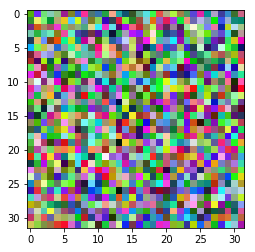

In [124]:
recon = sess.run(display_output, feed_dict={X: [train_X[5]]})
show_img(recon)